<a href="https://colab.research.google.com/github/Priyal2801/DETECTING-CREDIT-CARD-FRAUD/blob/main/Copy_of_Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import wget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from skmultiflow.drift_detection.adwin import ADWIN
import os
from datetime import datetime
from scipy.integrate import romb
from scipy.optimize import curve_fit

<h1>Importing Dependencies</h1>

<h1>Downloading the Data and Creating the Dataset</h1>
<p>In this section we first create an array of dates, then we feed them to our download function for downloading the file, that file is then fed to filter function for filtering and creating data sets. Then that file is deleted.</p>
<p>Our study period is from 1st march 2020 to 1st April 2021. The data set is of two kinds, uptil 10th june 2020 the data for Indian states is not available, while from 10th june onwards we deal with state wise data</p>

<p>for period 1st march 2020 to 10th june 2020</p>

In [ ]:
url1 = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
wget.download(url1, 'covid_confirmed.csv')
url2 = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
wget.download(url2, 'covid_recovered.csv')
url3 = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
wget.download(url3, 'covid_death.csv')

100% [............................................................................] 398600 / 398600

'covid_death.csv'

In [ ]:
df = pd.read_csv('covid_confirmed.csv')
dfr = pd.read_csv('covid_recovered.csv')
dfd = pd.read_csv('covid_death.csv')

In [ ]:
def convertor(dates):
    new = []
    for date in dates:
        new.append(date.strftime('%m-%d-%Y'))
    return new

In [ ]:
mydates = pd.date_range('2020-06-10','2021-03-01').tolist()
dates = convertor(mydates)

In [ ]:
delhi = pd.DataFrame(columns = ['Date','Confirmed','Deaths','Recovered','Active'])
for date in dates:
    file = date + '.csv'
    url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"+ file
    wget.download(url,file)
    a = pd.read_csv(file)
    b = a[a['Province_State']=='Uttar Pradesh']
    delhi.loc[len(delhi.index)] = [date,int(b['Confirmed']),int(b['Deaths']),int(b['Recovered']),int(b['Active'])]
    os.remove(file)

NameError: ignored

In [ ]:
delhi

,Date,Confirmed,Deaths,Recovered,Active
0,06-10-2020,31309,905,11861,18543
1,06-11-2020,34687,1085,12731,20871
2,06-12-2020,34687,1085,12731,20871
3,06-13-2020,36824,1214,13398,22212
4,06-14-2020,38958,1271,14945,22742
...,...,...,...,...,...
260,02-25-2021,638593,10905,626519,1169
261,02-26-2021,638849,10906,626712,1231
262,02-27-2021,639092,10909,626876,1307
263,02-28-2021,639289,10910,627044,1335


<h1>Estimation of Points where data changes

In [ ]:
date_change = []
adwin = ADWIN()
for i in range(0,265):
    adwin.add_element(delhi['Confirmed'].iloc[i])
    if adwin.detected_change():
        date_change.append([delhi['Date'].iloc[i],i])

In [ ]:
date_change

[['07-11-2020', 31],
 ['08-12-2020', 63],
 ['10-15-2020', 127],
 ['11-16-2020', 159],
 ['12-18-2020', 191],
 ['01-19-2021', 223],
 ['02-20-2021', 255]]

<h1>Estimation of Gamma</h1>

In [ ]:
int_d = []
r = []
for i in range(31,63):
    r.append((delhi['Recovered'].iloc[i+5]-delhi['Recovered'].iloc[i])/31181000)
    int_d.append(romb(delhi['Active'].iloc[i:i+5]/31181000))

In [ ]:
X = np.array(int_d).reshape(-1,1)
y = np.array(r)
reg = LinearRegression()
reg.set_params(fit_intercept= False)
reg.fit(X, y)
r_squared = reg.score(X, y)
gamma = reg.coef_

In [ ]:
gamma = np.asscalar(gamma)

C:\Users\Omen\anaconda3\envs\rstudio\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  """Entry point for launching an IPython kernel.


In [ ]:
gamma

0.13319919029505942

In [ ]:
gamma = round(gamma,3)

In [ ]:
r_squared = round(r_squared,3)

<h1>Estimation of total Infected Individuals</h1>

In [ ]:
id_I = []
for i in range(31,63):
    id_I.append((delhi['Active'].iloc[i+5]-delhi['Active'].iloc[i])/31181000+0.5*(delhi['Recovered'].iloc[i+5]+delhi['Recovered'].iloc[i])/31181000-0.5*gamma*romb(delhi['Active'].iloc[i:i+5]/31181000))

In [ ]:
i_d = 0.03

In [ ]:
for i in range(0,len(id_I)):
    id_I[i] = id_I[i]/i_d

In [ ]:
u = []
for i in range(0,len(id_I)):
    u.append(0.07*id_I[i])

In [ ]:
for i in range(5,len(u)):
    u[i] = u[i]-u[i-5]

NameError: ignored

In [ ]:
u

[0.006373670574316982,
 0.006571242489787823,
 0.006674549833885072,
 0.006801363807019233,
 0.006969046291960799,
 0.0007633236529367956,
 0.0006828277578819954,
 0.0007231380969179944,
 0.0007311274843298443,
 0.0007037993866160185,
 0.006967554416685375,
 0.007132358168495299,
 0.0071911779241157076,
 0.0074032078706524765,
 0.007635598669655191,
 0.0015473160932524188,
 0.0015456541949216453,
 0.0015153447978172845,
 0.001430365188439778,
 0.0012565153613252143,
 0.007442162674800779,
 0.007559472541564367,
 0.0076987215269982805,
 0.007891408898581403,
 0.00817297674486006,
 0.0020146003242715446,
 0.001979226163131155,
 0.001920725407566574,
 0.0017837053965674733,
 0.00160278270314187,
 0.007877706488400464,
 0.007896001777673255]

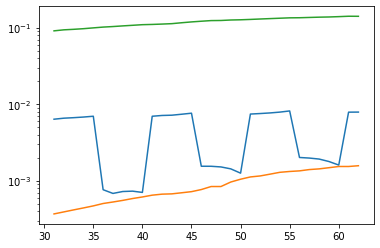

In [ ]:
plt.plot(range(31,63),u)
plt.plot(range(31,63),delhi['Active'].iloc[31:63]/31181000)
plt.plot(range(31,63),id_I)
plt.yscale('log')

In [ ]:
ru = []
for i in range(0,len(id_I)):
    ru.append(0.07*gamma*id_I[i])

In [ ]:
R = []
for i in range(0,len(id_I)):
    R.append(ru[i]+r[i])

In [ ]:
S = []
for i in range(0,len(id_I)):
    S.append(1-R[i]-id_I[i])

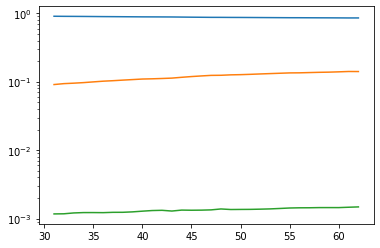

In [ ]:
plt.plot(range(31,63),S)
plt.plot(range(31,63),id_I)
plt.plot(range(31,63),R)
plt.yscale('log')